## 프로젝트 목표  
SQL과 Python을 활용해서 이커머스 사이트 고객들의 구매 기록을 보고,   고객 별 구매 패턴을 파악하여 세그멘테이션

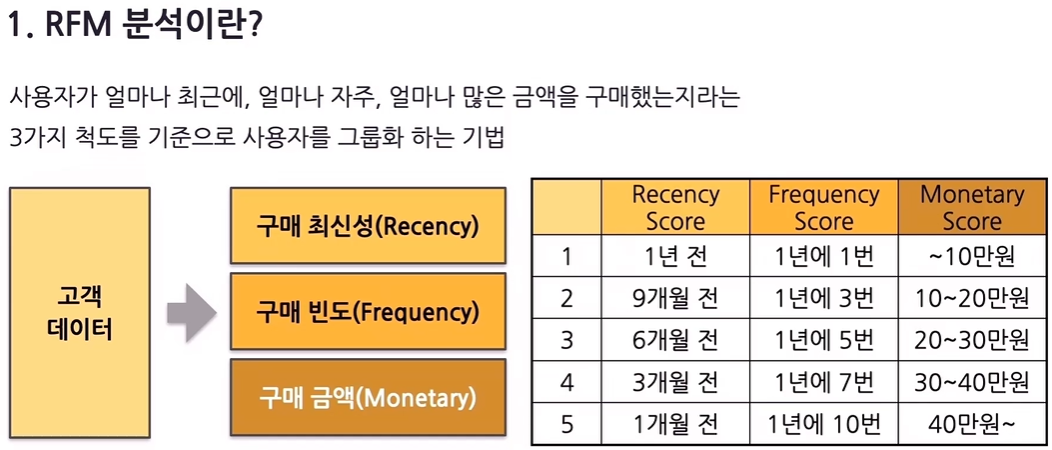

### RFM 분석
- __구매 최신성(Recency)__ , __구매 빈도(Frequency)__ 와 __구매 가치(Monetary)__ 에 따라 고객들을 여러 그룹으로 나누는 세그먼테이션(segmentation) 방법
- __Recency__: 고객이 마지막으로 구매한 시점.최근에 구매한 고객들은 더 자주 구매할 가능성이 높기 때문에, 최신성 점수가 높은지를 고려.
- __Frequency__: 특정 기간 동안 고객이 얼마나 자주 제품이나 서비스를 구매하는지를 나타냄. 빈번하게 구매를 하는 고객은 더 충성도가 높은 고객일 확률이 높기 때문에, 빈도 점수가 높은지를 고려.
- __Monetary__: 고객이 지출한 총 금액. 높은 금액을 지불한 고객일수록 더 가치가 높은 충성 고객일 수 있음. 앞으로도 제품과 사이트에 많은 돈을 지불할 수 있는 고객이므로, 가치 점수가 높은지를 함께 고려함.

### 분석 프로세스  
데이터셋 다운로드 →  
(SQL 분석 파트) 결측치 제거 → 중복값 처리 → 오류값 처리 → RFM 스코어 → 데이터 다운로드 →  
(파이썬 분석 파트) 이상치 처리 → 상관관계 분석 → 피처 스케일링 → 차원 축소 → K-Means 클러스터링 → 시각화/해석

### 프로젝트 루브릭
|평가 문항|상세기준|
|:---------|:--------|
|1. 빅쿼리를 자유롭게 사용할 수 있는가?|빅쿼리에 데이터를 정상적으로 업로드/다운로드하였고, SQL 쿼리문을 실행시켜 원하는 결과를 얻었다.|
|2. 문제 해결을 위해 필요한 SQL 쿼리문을 작성할 수 있는가?|SQL 쿼리문을 작성하여 데이터 전처리와 RFM 분석을 하고 추가 feature를 추출하였다.|
|3. SQL 쿼리문을 통해 얻은 결과로부터 적절한 인사이트를 얻었는가?|SQL 쿼리문을 통해 얻은 결과로부터 얻은 적절한 해석과 인사이트를 정리하여 제출하였다.|


# 데이터 불러오기

In [ ]:
# 테이블의 10개 행만 출력하기

select *
from `noble-serenity-411001.modulabs_project.data`
limit 10;

In [ ]:
# 테이블에서 전체 행 개수 확인하기

select count(*)
from `noble-serenity-411001.modulabs_project.data`;

총 8개의 컬럼, 541909개의 행이 있다.  

data.csv는 굉장히 많은 데이터가 저장된 파일이므로, 분석을 진행할 때 데이터 업로드 및 처리에 시간이 너무 오래 걸리는 것을 방지하기 위해 LIMIT을 넣어 먼저 데이터 일부를 확인해보는 것이 좋다.
<br/>
<br/>
### 데이터 처리 순서
1. 원하는 결과가 잘 나오는 쿼리인지 확인
2. LIMIT을 제거하여
3. 전체 데이터셋에 적용
```
✨ 실제 현업에서도 항상 모든 데이터를 가지고 분석을 하는 것이 아니라 소량의 테스트 데이터셋으로 분석을 진행해 본 이후, 전체 데이터셋에 적용하여 분석함
```

### 데이터의 특징

|컬럼명|설명|
|:------|:----|
|InvoiceNo|각각의 고유한 거래를 나타내는 코드. 이 코드가 'C'라는 글자로 시작한다면, 취소를 나타냅니다.<br>하나의 거래에 여러 개의 제품이 함께 구매되었다면, 1개의 InvoiceNo에는 여러 개의 StockCode가 연결되어 있습니다.|
|StockCode|각각의 제품에 할당된 고유 코드|
|Description|각 제품에 대한 설명|
|Quantity|거래에서 제품을 몇 개 구매했는지에 대한 단위 수|
|InvoiceDate|거래가 일어난 날짜와 시간|
|UnitPrice|제품 당 단위 가격(영국 파운드)|
|CustomerID|각 고객에게 할당된 고유 식별자 코드|
|Country|주문이 발생한 국가|

### 데이터 스키마
|필드 이름|유형|모드|
|:---------|:----|:----|
|InvoiceNo|STRING|NULLABLE|
|StockCode|STRING|NULLABLE|	
|Description|STRING|NULLABLE|
|Quantity|INTEGER|NULLABLE|
|InvoiceDate|TIMESTAMP|NULLABLE|
|UnitPrice|FLOAT|NULLABLE|
|CustomerID|INTEGER|NULLABLE|
|Country|STRING|NULLABLE|  

<br>
Quantity 컬럼에는 정수(interger) 타입, UnitPrice 컬럼에는 실수(float) 타입 데이터가 저장되어 있다.

```
✨ 데이터의 스키마를 살펴보면 각 컬럼들이 연산이 가능한 숫자형 데이터인지, 아니면 텍스트 데이터인지를 이해할 수 있기 때문에 보다 깊이 있게 분석할 수 있음
```

### 데이터 수 세기

In [ ]:
select 
  count(InvoiceNo) as count_InvoiceNo,
  count(StockCode) as count_StockCode,
  count(Description) as count_Description,
  count(Quantity) as count_Quantity,
  count(InvoiceDate) as count_InvoiceDate,
  count(UnitPrice) as count_UnitPrice,
  count(CustomerID) as count_CustomerID,
  count(Country) as count_country
from `noble-serenity-411001.modulabs_project.data`

|count_InvoiceNo|count_StockCode|count_Description|count_Quantity|count_InvoiceDate|count_UnitPrice|count_CustomerID|count_Country|
|:-|:-|:-|:-|:-|:-|:-|:-|
|541909|541909|540455|541909|541909|541909|406829|541909|

### 결측치 확인

In [ ]:
select 
  count(*) as count_all
  count(InvoiceNo) as count_InvoiceNo,
  count(StockCode) as count_StockCode,
  count(Description) as count_Description,
  count(Quantity) as count_Quantity,
  count(InvoiceDate) as count_InvoiceDate,
  count(UnitPrice) as count_UnitPrice,
  count(CustomerID) as count_CustomerID,
  count(Country) as count_country
from `noble-serenity-411001.modulabs_project.data`

count(*)는 모든 행의 개수를 세고, count(column_name)은 null(결측치)값을 제외한 행의 개수를 센다.  

|count_all|count_InvoiceNo|count_StockCode|count_Description|count_Quantity|count_InvoiceDate|count_UnitPrice|count_CustomerID|count_Country|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|541909|541909|541909|540455|541909|541909|541909|406829|541909|

따라서, 결측치가 있는 컬럼은 Description과 CustomerID이다.

# 데이터 전처리

## 데이터의 종류
### 1. 범주형
- 몇 개의 범주 또는 그룹으로 나뉜 데이터
- 명목형: 성별, 색, 혈액형, 주거지역 등과 같이 단순히 분류되는 데이터로, 순서가 없고 개수나 퍼센트로 표현할 수 있음.
- 순서형: 만족도, 병의 단계, 성적 등과 같이 각 값들이 이산적이고 값들 사이에 순서 가 존재하는 데이터로, 평균을 구할 수 있음.

### 2. 수치형 (양적)
- 수치적 의미가 있어 연산이 가능한 데이터
- 이산형: 횟수, 차량 수, 사고 건수 등과 같이 이산적인 값을 갖는 데이터로, 값이 정수이기 때문에 퍼센트로 표현됨.
- 연속형: 키, 몸무게, 온도 등과 같이 연속적인 값을 갖는 데이터로, 평균, 표준편차, 분산, 퍼센트 등으로 표현할 수 있음.

## 자주 사용되는 데이터 전처리 방법  

### 1. 결측치 처리
- 결측치: 데이터가 비어 있는 값  
- 결측치가 존재하는 행을 삭제하거나,  
- 다른 값들의 평균, 중앙값, 최빈값으로 대체  

### 2. 중복값 처리
- 중복값: 데이터셋에서 똑같은 정보를 가진 반복된 행  
- 중복값은 데이터의 전체적인 품질을 저하시키고 분석의 정확도를 떨어뜨림  
- 중복된 행을 식별하고 제거하는 것은 데이터의 일관성과 정확성을 유지하기 위해 필수적인 단계이나,<br/> 경우에 따라서는 특정 조건이나 규칙에 따라 중복된 데이터를 유지해야 할 수 있음<br/> → 데이터의 특성에 따라 판단  

### 3. 정규화 및 표준화
- 정규화와 표준화를 통해 데이터의 범위를 일정하게 조정하거나, 데이터의 스케일을 변경할 수 있음
- 단위의 차이가 큰 데이터의 범위를 0과 1 사이의 숫자로 변경하거나,
- 로그 변환이나 제곱근 변환 등을 통해 데이터 분포를 조정

### 4. 범주형(명목형) 데이터의 인코딩
- 성별이나 구매 지역 등의 범주형(명목형) 데이터를 수치형으로 변환하는 전처리 방법
- 예시: 여성 0, 남성 1

### 5. 이상치 분석 및 처리
- 통계적인 방법이나 시각적 도구를 활용해서 값이 극단적으로 크거나 작은 이상치(outlier)들을 찾고, 필요에 따라 제거하거나 수정하여 사용
<img src="https://d3s0tskafalll9.cloudfront.net/media/images/SeuKeuLinSyas_2023-12-08_150248.max-800x600.png" width="400" height="300">

# 데이터 전처리(1): 결측치 제거

In [ ]:
# 결측치가 있는 Description, CustomerID 컬럼에서 누락된 값의 비율을 계산

SELECT
    'Description' AS column_name,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM `noble-serenity-411001.modulabs_project.data`
UNION ALL
SELECT
    'CustomerID' AS column_name,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM `noble-serenity-411001.modulabs_project.data`;

| column_name | missing_percentage |
|:-|:-|
| CustomerID  | 24.93              |
| Description | 0.27               |

## 결측치 처리 전략
### CustomerID (결측치 24.93%)
- 누락된 CustomerID가 있는 행을 삭제

### Description (결측치 0.27%)
- 결측치는 적지만 데이터 일관성 문제가 있으므로 누락된 설명이 있는 행을 제거

In [ ]:
# Description 컬럼의 일관성 문제
# Description 컬럼에서 StockCode가 '85123A'인 행 출력
select Description
from `noble-serenity-411001.modulabs_project.data`
where StockCode = '85123A'
group by Description

|Description|
|:-|
|?|
|wrongly marked carton 22804|
|CREAM HANGING HEART T-LIGHT HOLDER|
|WHITE HANGING HEART T-LIGHT HOLDER|

In [ ]:
# 결측치 삭제
delete from `noble-serenity-411001.modulabs_project.data`
where Description is null or CustomerID is null;

'이 문으로 data의 행 135,080개가 삭제되었습니다.'가 출력된다.

In [ ]:
# 결측치 삭제 후 데이터 확인

select 
  count(*),
  count(InvoiceNo) as count_InvoiceNo,
  count(StockCode) as count_StockCode,
  count(Description) as count_Description,
  count(Quantity) as count_Quantity,
  count(InvoiceDate) as count_InvoiceDate,
  count(UnitPrice) as count_UnitPrice,
  count(CustomerID) as count_CustomerID,
  count(Country) as count_country
from `noble-serenity-411001.modulabs_project.data`

| f0_    | count_InvoiceNo | count_StockCode | count_Description | count_Quantity | count_InvoiceDate | count_UnitPrice | count_CustomerID | count_country |
|:--------|:-----------------|:-----------------|:-------------------|:----------------|:-------------------|:-----------------|:------------------|:---------------|
| 406829 | 406829          | 406829          | 406829            | 406829         | 406829            | 406829          | 406829           | 406829        |


결측치가 삭제되어 모든 컬럼에 대해 데이터의 개수가 동일해졌다.

# 데이터 전처리(2): 중복값 제거

### 중복값 확인

In [ ]:
select count(*) as duplicates
from (
  select *
  from `noble-serenity-411001.modulabs_project.data`
  group by InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
  having count(*) >1
);

각 그룹 내의 모든 행 수를 계산하고 (서브쿼리), 그 수를 모두 합산한다.

### 중복값 처리

In [ ]:
# 완전히 동일한 중복항들을 제거하고 데이터 파일을 업데이트

create or replace table `noble-serenity-411001.modulabs_project.data_distinct` as
select distinct *
from `noble-serenity-411001.modulabs_project.data`

'이 문으로 이름이 data인 테이블이 교체되었습니다.'가 출력된다.

In [ ]:
# 중복값을 처리한 후의 데이터 행 수

select count(*)
from `noble-serenity-411001.modulabs_project.data_distinct`;

|f0_|
|:-|
|401604|

중복값이 처리되어 행 수가 406829에서 401604로 감소했다.

# 데이터 전처리(3): 오류값 처리
컬럼 단위로 데이터를 살펴보면서 클렌징이 필요한 값들이 있는지 살펴보기

### ```InvoiceNo``` 살펴보기

In [ ]:
# 고유(unique)한 InvoiceNo의 개수를 출력

select count(distinct(InvoiceNo))
from `noble-serenity-411001.modulabs_project.data_distinct`;

|f0_|
|:-|
|22190|

In [ ]:
# 고유(unique)한 InvoiceNo의 데이터를 출력

select distinct(InvoiceNo)
from `noble-serenity-411001.modulabs_project.data_distinct`
limit 100;

|InvoiceNo|
|:-|
|574301|
|C575531|
|557305|
|543008|
|549735|
|...|
|574573|
|545419|
|554917|
|C558080|
|573418|

몇 개의 InvoiceNo는 'C'로 시작한다. 즉 취소된거래가 InvoiceNo에 포함되어 있다.  
고객 행동과 제품 선호도에 대한 이해를 높이기 위해서는 취소된 거래들도 고려해야 한다. 따라서, 취소 데이터들을 확인해보자.

In [ ]:
# InvoiceNo가 'C'로 시작하는 행을 필터링

select *
from `noble-serenity-411001.modulabs_project.data_distinct`
where InvoiceNo like 'C%'
limit 100;

| InvoiceNo | StockCode | Description                      | Quantity | InvoiceDate                    | UnitPrice | CustomerID | Country        |
|:-----------|:-----------|:----------------------------------|:----------|:-------------------------------|:-----------|:------------|:----------------|
| C575531   | 22960     | JAM MAKING SET WITH JARS         | -4       | 2011-11-10 11:12:00.000000 UTC | 4.25      | 12544      | Spain          |
| C558080   | 22847     | BREAD BIN DINER STYLE IVORY      | -1       | 2011-06-26 11:35:00.000000 UTC | 16.95     | 15104      | United Kingdom |
| C558080   | 22840     | ROUND CAKE TIN VINTAGE RED       | -1       | 2011-06-26 11:35:00.000000 UTC | 7.95      | 15104      | United Kingdom |
| C554983   | 47590A    | BLUE HAPPY BIRTHDAY BUNTING      | -20      | 2011-05-29 12:18:00.000000 UTC | 4.65      | 17152      | United Kingdom |
| C554983   | 47590B    | PINK HAPPY BIRTHDAY BUNTING      | -20      | 2011-05-29 12:18:00.000000 UTC | 4.65      | 17152      | United Kingdom |
| C539709   | 21485     | RETROSPOT HEART HOT WATER BOTTLE | -1       | 2010-12-21 12:33:00.000000 UTC | 4.95      | 18176      | United Kingdom |
| C539709   | 84978     | HANGING HEART JAR T-LIGHT HOLDER | -1       | 2010-12-21 12:33:00.000000 UTC | 1.25      | 18176      | United Kingdom |
| C539709   | 22832     | BROCANTE SHELF WITH HOOKS        | -2       | 2010-12-21 12:33:00.000000 UTC | 10.75     | 18176      | United Kingdom |
| C543620   | 21217     | RED RETROSPOT ROUND CAKE TINS    | -1       | 2011-02-10 14:52:00.000000 UTC | 9.95      | 14081      | United Kingdom |
| C546858   | 21534     | DAIRY MAID LARGE MILK JUG        | -1       | 2011-03-17 14:24:00.000000 UTC | 4.95      | 14081      | United Kingdom |
|...|

재고값이 음수(Quantity < 0)일 때 반품되었다.

In [ ]:
# 구매 건 상태가 Canceled 인 데이터의 비율(%) 계산

select round(sum(case when InvoiceNo like 'C%' THEN 1 ELSE 0 END) *100 / count(*), 1)  as calcellation_rate
# round(data, 1): 소수 첫번째자리까지 계산
FROM `noble-serenity-411001.modulabs_project.data_distinct`

|calcellation_rate|
|:-|
|2.2|

### ```StockCode``` 살펴보기

In [ ]:
# 고유한 StockCode의 개수를 출력

select count(distinct(StockCode))
from `noble-serenity-411001.modulabs_project.data_distinct`;

|f0_|
|:-|
|3684|

In [ ]:
# StockCode 별 등장 빈도(어떤 제품이 가장 많이 판매되었는지) 출력

select StockCode, count(*) as sell_cnt 
from `noble-serenity-411001.modulabs_project.data_distinct`
group by StockCode
order by sell_cnt desc
limit 10;   # 상위 10개만 출력

| StockCode | sell_cnt |
|:-----------|:----------|
| 85123A    | 2065     |
| 22423     | 1894     |
| 85099B    | 1659     |
| 47566     | 1409     |
| 84879     | 1405     |
| 20725     | 1346     |
| 22720     | 1224     |
| POST      | 1196     |
| 22197     | 1110     |
| 23203     | 1108     |


대부분의 StockCode들은 5-6 자리 숫자이며, StockCode 중 'POST'는 이상치로 보인다.  
현재 진행하고 있는 프로젝트는 고객들의 제품 구매에 초점이 맞춰져 있기 때문에 이런 값들은 제거하는 것이 좋을 것 같다.

In [ ]:
# StockCode의 문자열 내 숫자의 길이 구하기

with UniqueStockCodes as (
  select distinct StockCode
  from `noble-serenity-411001.modulabs_project.data_distinct`
)
select
  length(StockCode) - length(regexp_replace(StockCode, r'[0-9]', '')) AS number_count,
  # 텍스트를 처리하는 정규 표현식(Regular Expression) 중 하나인 regexp_replace 
  # regexp = 정규 표현식, replace = 텍스트를 대체함
  # regexp_replace = 특정 조건에 부합한 텍스트를 다른 텍스트로 대체
  
  # StockCode 컬럼에 있던 값 중에서 0부터 9 사이의 숫자([0-9])를 비어 있는 값(’’)으로 대체하여 문자만 남김
  # 최종적으로 [StockCode 값의 길이 - StockCode 값의 "문자" 길이 = StockCode값의 "숫자" 길이]가 됨
  count(*) as stock_cnt
from UniqueStockCodes
group by number_count
order by stock_cnt desc;

|number_count|stock_cnt|
|:-|:-|
|5|3676|
|0|7|
|1|1|

숫자가 0개인 코드 7개와 숫자가 1개인 코드 1개, 즉 8개를 제외하고는 StockCode에 5개의 숫자들이 포함되어 있다.

In [ ]:
# 숫자가 0~1개인 값들에는 들어있는 코드들 확인
SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM `noble-serenity-411001.modulabs_project.data_distinct`
) 
WHERE number_count = 0 or number_count = 1;

| StockCode     | number_count |
|:---------------|:--------------|
| POST          | 0            |
| M             | 0            |
| PADS          | 0            |
| D             | 0            |
| BANK CHARGES  | 0            |
| DOT           | 0            |
| CRUK          | 0            |
| C2            | 1            |


In [ ]:
# 해당 코드 값들을 가지고 있는 데이터 수는 전체 데이터 수 대비 몇 퍼센트인지 계산

select
  round(sum(case when length(StockCode) - length(regexp_replace(StockCode, r'[0-9]', '')) = 0 
                 or length(StockCode) - length(regexp_replace(StockCode, r'[0-9]', '')) = 1 
            then 1 else 0 end) * 100.0 / count(*), 2) AS str_rate
from 
  `noble-serenity-411001.modulabs_project.data_distinct`;

|str_rate|
|:-|
|0.48|

전체 데이터 중 매우 작은 비율인 0.48%의 데이터가 일반적인 형식에서 벗어난 값을 가지고 있음.
프로젝트의 목표는 고객들의 '제품 구매'에 기반하여 세그먼테이션을 하는 것이므로, 이런 StockCode가 포함된 기록은 데이터셋에서 제외한다.

In [ ]:
# 제품과 관련되지 않은 거래 기록을 제거

DELETE FROM `noble-serenity-411001.modulabs_project.data_distinct`
WHERE StockCode IN (
  SELECT DISTINCT StockCode
  FROM (
    SELECT StockCode,
      LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
    FROM `noble-serenity-411001.modulabs_project.data_distinct`
  ) 
  WHERE number_count = 0 OR number_count = 1
);

실행하면 '이 문으로 data_distinct의 행 1,915개가 삭제되었습니다'가 출력된다.

### ```Description``` 살펴보기

In [ ]:
# 고유한 Description 별 출현 빈도를 계산하고 상위 30개를 출력

SELECT Description, COUNT(*) AS description_cnt
FROM `noble-serenity-411001.modulabs_project.data_distinct`
GROUP BY Description
LIMIT 30;

| Description                         | description_cnt |
|:-------------------------------------|:-----------------|
| ASSORTED COLOUR BIRD ORNAMENT        | 1405            |
| PINK BLUE FELT CRAFT TRINKET BOX     | 465             |
| SCANDINAVIAN REDS RIBBONS            | 343             |
| PAPER CHAIN KIT VINTAGE CHRISTMAS    | 718             |
| CHRISTMAS CRAFT LITTLE FRIENDS       | 433             |
| JAM MAKING SET WITH JARS             | 966             |
| PAPER CHAIN KIT 50'S CHRISTMAS       | 1013            |
| FELTCRAFT PRINCESS OLIVIA DOLL       | 254             |
| FELTCRAFT PRINCESS LOLA DOLL         | 383             |
| TRADITIONAL CHRISTMAS RIBBONS        | 272             |
| POSTAGE                              | 1196            |
| TRADITIONAL KNITTING NANCY           | 523             |
| ASSORTED COLOUR MINI CASES           | 372             |
| EMBROIDERED RIBBON REEL SALLY        | 63              |
| SET OF 4 KNICK KNACK TINS DOILY      | 328             |
| EMBROIDERED RIBBON REEL EMILY        | 87              |
| 6 RIBBONS RUSTIC CHARM               | 747             |
| EMBROIDERED RIBBON REEL ROSIE        | 49              |
| SET OF 6 RIBBONS VINTAGE CHRISTMAS   | 343             |
| HANGING JAM JAR T-LIGHT HOLDER       | 321             |
| PINK BABY BUNTING                    | 207             |
| GIRLS VINTAGE TIN SEASIDE BUCKET     | 139             |
| BINGO SET                            | 283             |
| HANGING ENGRAVED METAL HEART         | 75              |
| PARTY BUNTING                        | 1409            |
| SPOTTY BUNTING                       | 1026            |
| "NURSERY A,B,C PAINTED LETTERS"      | 67              |
| RED RETROSPOT SHOPPER BAG            | 391             |
| RED GINGHAM ROSE JEWELLERY BOX       | 231             |
| SMALL WHITE HEART OF WICKER          | 600             |


제품군들이 대부분 가정용품, 주방용품, 점심 도시락, 장식품과 관련된 것들임.  

모든 Description이 대문자로 되어 있는데, 이는 데이터베이스에 제품 설명을 입력할 때 사용되는 표준화된 형식일 수도 있음.  
그러나 혹시라도 대문자와 소문자가 혼합된 스타일로 입력된 설명이 있는지 확인해봐야 함.

In [ ]:
# 대소문자가 혼합된 Description이 있는지 확인

SELECT DISTINCT Description
FROM `noble-serenity-411001.modulabs_project.data_distinct`
WHERE REGEXP_CONTAINS(Description, r'[a-z]');
# REGEXP_CONTAINS 함수: 특정 패턴이 문자열에 포함되어 있는지 여부를 확인하는 데에 유용
# True = 특정 패턴이 문자열에 포함되어 있음, False = 특정 패턴이 문자열에 포함되어 있지 않음
# REGEXP_CONTAINS(Description, r’[a-z]’) = Description 컬럼에 있는 문자열에서 소문자 알파벳([a-z])이 포함되어 있는지를 확인

| Description                           |
|:---------------------------------------|
| BAG 125g SWIRLY MARBLES               |
| 3 TRADITIONAl BISCUIT CUTTERS  SET    |
| Manual                                |
| BAG 250g SWIRLY MARBLES               |
| ESSENTIAL BALM 3.5g TIN IN ENVELOPE   |
| "FOLK ART GREETING CARD,pack/12"      |
| BAG 500g SWIRLY MARBLES               |
| Discount                              |
| POLYESTER FILLER PAD 45x45cm          |
| POLYESTER FILLER PAD 40x40cm          |
| Next Day Carriage                     |
| FRENCH BLUE METAL DOOR SIGN No        |
| Bank Charges                          |
| High Resolution Image                 |
| CRUK Commission                       |
| POLYESTER FILLER PAD 45x30cm          |
| POLYESTER FILLER PAD 30CMx30CM        |
| NUMBER TILE COTTAGE GARDEN No         |
| NUMBER TILE VINTAGE FONT No           |
| FLOWERS HANDBAG blue and orange       |
| THE KING GIFT BAG 25x24x12cm          |
| POLYESTER FILLER PAD 65CMx65CM        |
| POLYESTER FILLER PAD 60x40cm          |


출력 결과를 보면 사이즈(cm)나 무게(g) 등의 단위를 나타내는 설명이 포함되어 있고, 'Next Day Carriage'나 'High Resolution Image'와 같은 일부 항목들처럼 실제 제품에 대한 Description이 아닌 것도 있음.  
이 데이터들은 실제 제품 정보와 관련이 없어 보인다. 다른 유형의 정보나 서비스 세부사항을 나타내는 것일수도 있음.  
이를 처리하기 위한 몇가지 전략들을 생각해볼 수 있습니다.

1. 'Next Day Carriage'와 'High Resolution Image'와 같은 서비스 관련 정보를 포함하는 행들을 제거
2. 대소문자를 혼합해서 사용하는 경우, 대문자로 표준화하여 데이터셋 전체에서 일관성 유지. 이는 대소문자에 의한 중복 항목의 가능성을 줄이는 데에도 도움이 될 것

이러한 전략을 선택함으로써, 데이터셋의 품질을 향상시킬 수 있고 프로젝트의 분석 단계에 더 적합한 데이터셋을 완성할 수 있음.

In [ ]:
# 서비스 관련 정보를 포함하는 행들을 제거

DELETE
FROM `noble-serenity-411001.modulabs_project.data_distinct`
WHERE Description IN ('Manual', 'Discount', 'Next Day Carriage', 'High Resolution Image', 'CRUK Commission');

'이 문으로 data_distinct의 행 636개가 삭제되었습니다.'가 출력된다.

In [ ]:
# 2. 대소문자를 혼합하고 있는 데이터를 대문자로 표준화

CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.data_dist_upper` AS
SELECT
  * EXCEPT (Description),
# * EXCEPT (CustomerID) = 테이블의 모든 컬럼들을 가져오되, Description은 제외하라
  UPPER(Description) AS Description 
FROM `noble-serenity-411001.modulabs_project.data_distinct`;

실행하면 '이 문으로 이름이 data_dist_upper인 새 테이블이 생성되었습니다.'가 출력된다.

### UnitPrice 살펴보기
UnitPrice에서 이상치 찾기

In [ ]:
# 최솟값, 최댓값, 평균 데이터를 통해 단위 가격의 요약 통계량 확인
# 단위 가격: 상품 1개 당 가격

SELECT MIN(UnitPrice) AS min_price, MAX(UnitPrice) AS max_price, ROUND(AVG(UnitPrice),2) AS avg_price
FROM `noble-serenity-411001.modulabs_project.data_dist_upper`;

|min_price|max_price|avg_price|
|:-|:-|:-|
|0.0|8142.75|3.05|

최소 단위 가격(min_price)이 0.  
이는 단가가 0원인 데이터가 존재한다는 것을 의미하고, 이는 이 제품이 무료 제품이거나 데이터 오류일 수도 있다는 의미.  

단가 0원인 제품을 상세하게 분석해보면서 특정한 패턴이 있는지 살펴보자.

In [ ]:
# 단가가 0원인 거래의 개수, 구매 수량(Quantity)의 최솟값, 최댓값, 평균

SELECT COUNT(Quantity) AS cnt_quantity, MIN(Quantity) AS min_quantity, MAX(Quantity) AS max_quantity, round(AVG(Quantity), 2) AS avg_quantity
FROM `noble-serenity-411001.modulabs_project.data_dist_upper`
WHERE UnitPrice = 0;

|cnt_quantity|min_quantity|max_quantity|avg_quantity|
|:-|:-|:-|:-|
|33|1|12540|408.18|

UnitPrice가 0인 행의 수는 33개로 비교적 적으며, 구매 수량(Quantity)은 최소 1개부터 최대 12,540개에 이르기까지 굉장히 큰 편차를 가짐.  
데이터의 수가 적은 것으로 미루어보아 무료 제품이라기보다 데이터 오류일 가능성이 높으므로,  
UnitPrice = 0인 데이터를 제거하여 데이터 일관성을 유지하자.

In [ ]:
# UnitPrice = 0를 제거

CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.data_pre` AS 
SELECT *
FROM `noble-serenity-411001.modulabs_project.data_dist_upper`
WHERE UnitPrice != 0;

실행하면 '이 문으로 이름이 data_pre인 새 테이블이 생성되었습니다.'가 출력된다.

나머지 컬럼들에 대해서도 이와 같은 순서로 분석을 진행하면 된다.  
다만 다른 컬럼들에 대해서는 크게 오류값 처리를 할 것이 없기 때문에, 오류값 처리 파트는 여기에서 마무리!

# RFM 스코어

## Recency
- 특정 기간 동안 고객이 얼마나 자주 우리의 제품이나 서비스를 구매하는지
- 고객이 최근에 얼마나 구매했는지에 중점  
➡️ '마지막 구매일로부터 현재까지 경과한 일수'를 계산해야 함
    - 값이 작을수록 최근에 구매했음을 의미

In [ ]:
# InvoiceDate를 '2010-12-01 08:26:00'와 같은 'YYYY-MM-DD HH:MM:SS' 형태에서 'YYYY-MM-DD' 형태로 날짜에 해당하는 부분만 남기기

SELECT DATE(InvoiceDate) AS InvoiceDay, *
FROM `noble-serenity-411001.modulabs_project.data_pre`;

InvoiceDay 컬럼에 날짜가 YYYY-MM-DD 형태로 저장된다.

현재 다루고 있는 데이터는 2010년~2011년 사이의 데이터로, 최종 구매일로부터 꽤 오랜 시간이 지난 데이터임  
그래서 이번 프로젝트에서는 모든 고객들을 통틀어 가장 최근 구매 일자를 기준으로 Recency를 구한다.

In [ ]:
# 가장 최근 구매 일자 찾기

SELECT 
   MAX(InvoiceDate) AS most_recent_date, 
FROM `noble-serenity-411001.modulabs_project.data_pre`;

가장 최근 구매 일자는 2011월 12월 09일이다.

In [ ]:
# 유저 별로 가장 큰 InvoiceDay를 찾아서 가장 최근 구매일로 저장

SELECT 
    CustomerID,
    DATE(MAX(InvoiceDate)) AS InvoiceDay
FROM `noble-serenity-411001.modulabs_project.data_pre`
GROUP BY CustomerID
LIMIT 10;

| CustomerID | InvoiceDay  |
|------------|-------------|
| 12544      | 2011-11-10  |
| 13568      | 2011-06-19  |
| 13824      | 2011-11-07  |
| 14080      | 2011-11-07  |
| 14336      | 2011-11-23  |
| 14592      | 2011-11-04  |
| 15104      | 2011-06-26  |
| 15360      | 2011-10-31  |
| 15872      | 2011-11-25  |
| 16128      | 2011-11-22  |

In [ ]:
# 가장 최근 일자(most_recent_date)와 유저별 마지막 구매일(InvoiceDay)간의 차이 계산

SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
  # InvoiceDay에서 일자만 추출
  # MAX(InvoiceDay) OVER () - InvoiceDay = 전체 데이터셈 마지막 구매일 - 고객 별 각 구매일
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
)
LIMIT 10;

| CustomerID | recency |
|------------|---------|
| 18179      | 9       |
| 15111      | 29      |
| 13849      | 51      |
| 14108      | 30      |
| 17704      | 168     |
| 18216      | 31      |
| 16945      | 21      |
| 18226      | 38      |
| 16184      | 64      |
| 15423      | 38      |

In [ ]:
# 지금까지의 결과를 user_r이라는 이름의 테이블로 저장
CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_r` AS
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
);


# 테이블 확인
SELECT *
FROM  `noble-serenity-411001.modulabs_project.user_r`
LIMIT 5;

| CustomerID | recency |
|------------|---------|
| 16558      | 0       |
| 16954      | 0       |
| 15311      | 0       |
| 15804      | 0       |
| 12518      | 0       |

## Frequency

#### 1. 전체 거래 건수 계산

In [ ]:
# 고객마다 고유한 InvoiceNo의 수 세기

SELECT
  CustomerID,
  COUNT(DISTINCT(InvoiceNo)) AS purchase_cnt
FROM `noble-serenity-411001.modulabs_project.data_pre`
GROUP BY CustomerID
LIMIT 10;

| CustomerID | purchase_cnt |
|------------|--------------|
| 12544      | 2            |
| 13568      | 1            |
| 13824      | 5            |
| 14080      | 1            |
| 14336      | 4            |
| 14592      | 3            |
| 15104      | 3            |
| 15360      | 1            |
| 15872      | 2            |
| 16128      | 5            |


#### 2. 구매한 아이템의 총 수량 계산

In [ ]:
# 각 고객 별로 구매한 아이템의 총 수량 구하기

SELECT
  CustomerID,
  SUM(Quantity) AS item_cnt
FROM `noble-serenity-411001.modulabs_project.data_pre`
GROUP BY CustomerID
LIMIT 10;

| CustomerID | item_cnt |
|------------|----------|
| 12544      | 130      |
| 13568      | 66       |
| 13824      | 768      |
| 14080      | 48       |
| 14336      | 1759     |
| 14592      | 407      |
| 15104      | 633      |
| 15360      | 223      |
| 15872      | 187      |
| 16128      | 988      |

#### 3. '1. 전체 거래 건수 계산'과 '2. 구매한 아이템의 총 수량 계산'의 결과를 합쳐서 user_rf라는 이름의 테이블에 저장

In [ ]:
CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_rf` AS

# 1. 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
    CustomerID,
    COUNT(DISTINCT(InvoiceNo)) AS purchase_cnt
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
),

# 2. 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
    CustomerID,
    SUM(Quantity) AS item_cnt
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
)

# 3. 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN `noble-serenity-411001.modulabs_project.user_r` AS ur
  ON pc.CustomerID = ur.CustomerID;

In [4]:
# 데이터 확인


SELECT *
FROM `noble-serenity-411001.modulabs_project.user_rf`
ORDER BY CustomerID
LIMIT 10;

| CustomerID | purchase_cnt | item_cnt | recency |
|------------|--------------|----------|---------|
| 12346      | 2            | 0        | 325     |
| 12347      | 7            | 2458     | 2       |
| 12348      | 4            | 2332     | 75      |
| 12349      | 1            | 630      | 18      |
| 12350      | 1            | 196      | 310     |
| 12352      | 8            | 463      | 36      |
| 12353      | 1            | 20       | 204     |
| 12354      | 1            | 530      | 232     |
| 12355      | 1            | 240      | 214     |
| 12356      | 3            | 1573     | 22      |

## Monetary
- 고객이 지불한 총 금액에 초점
- 총 지출액을 계산할수도 있고, 거래당 평균 거래 금액을 계산할 수도 있음
- 결제한 총 금액이 높은 고객을 찾는 것도 좋지만, 한번에 많이 구매하는 고객들을 찾는 것도 중요

#### 1. 고객별 총 지출액 계산

In [ ]:
# 고객별 총 지출액을 계산
# 소수점 첫째 자리에서 반올림

SELECT
  CustomerID,
  ROUND(SUM(UnitPrice * Quantity), 1) AS user_total   # 총 지출액은 단위 금액 * 수량으로 계산해야 한다.
FROM `noble-serenity-411001.modulabs_project.data_pre`
GROUP BY CustomerID
LIMIT 10;

| CustomerID | user_total |
|------------|------------|
| 12544      | 299.7      |
| 13568      | 187.1      |
| 13824      | 1698.9     |
| 14080      | 45.6       |
| 14336      | 1614.9     |
| 14592      | 557.9      |
| 15104      | 968.6      |
| 15360      | 427.9      |
| 15872      | 316.2      |
| 16128      | 1880.2     |


#### 2. 고객별 평균 거래 금액 계산

In [ ]:
# 고객별 평균 거래 금액을 구하기 위해
# 1) data 테이블을 user_rf 테이블과 조인(LEFT JOIN) 한 후,
# 2) purchase_cnt로 나누어서
# 3) user_rfm 테이블로 저장

CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_rfm` AS   
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  ut.user_total / rf.purchase_cnt AS user_average
FROM `noble-serenity-411001.modulabs_project.user_rf` rf
LEFT JOIN (
  SELECT
    CustomerID,
    ROUND(SUM(UnitPrice * Quantity), 1) AS user_total
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
) ut
ON rf.CustomerID = ut.CustomerID;

'이 문으로 이름이 user_rfm인 새 테이블이 생성되었습니다.'

## RFM 통합 테이블 출력하기

In [ ]:
SELECT *
FROM `noble-serenity-411001.modulabs_project.user_rfm`
LIMIT 10;

| CustomerID | purchase_cnt | item_cnt | recency | user_total | user_average |
|------------|--------------|----------|---------|------------|--------------|
| 12713      | 1            | 505      | 0       | 794.6      | 794.6        |
| 12792      | 1            | 215      | 256     | 344.5      | 344.5        |
| 15083      | 1            | 38       | 256     | 88.2       | 88.2         |
| 18010      | 1            | 60       | 256     | 174.8      | 174.8        |
| 15520      | 1            | 314      | 1       | 343.5      | 343.5        |
| 14569      | 1            | 79       | 1       | 227.4      | 227.4        |
| 13298      | 1            | 96       | 1       | 360.0      | 360.0        |
| 13436      | 1            | 76       | 1       | 196.9      | 196.9        |
| 14476      | 1            | 110      | 257     | 193.0      | 193.0        |
| 13357      | 1            | 321      | 257     | 609.4      | 609.4        |


# 추가 Feature 추출

- RFM 분석 방법의 허점
    - RFM 분석으로는 사이트에 방문한 횟수가 동일하고 비슷한 금액을 지출했지만 구매 패턴이 다른 사람을 분류하지 못함
    - 예시: 10개의 서로 다른 제품을 구매한 사람과 1개 상품을 10개 구매한 사람은 분명 다른 쇼핑 패턴을 가지고 있지만,  
        RFM 분석으로는 같은 그룹으로 구분함  

- 또한, 커머스에서 구매하는 제품의 폭이 넓은 사람일수록, 장기적으로 봤을 때 온라인 커머스 사이트에서 구매를 더 많이 할 가능성이 높아짐

유저의 구매 패턴 속에서 뽑아낼 수 있는 추가적인 특징들이 있을지 살펴보자.  
크게 아래와 같이 3가지 측면에서 데이터를 분석.  

1. 구매하는 제품의 다양성
2. 평균 구매 주기
3. 구매 취소 경향성

## 클러스터링 알고리즘이란?
- 비슷한 특성을 가진 데이터 포인트들을 그룹화하는 기술
- 데이터 속에 숨겨진 구조나 패턴을 찾아서 비슷한 데이터들끼리 그룹짓기  


### 클러스터링 활용 사례
1. 고객 세그먼테이션: 고객 데이터를 기반으로 비슷한 구매 패턴이나 선호도를 가진 고객 그룹을 찾아서 타겟 마케팅 전략을 최적화
2. 이미지 분류: 비슷한 특징을 가진 이미지를 그룹화하여 이미지 검색 또는 분류를 개선
3. 자연어 처리: 비슷한 주제를 가진 문서를 그룹화하여 정보 검색 및 텍스트 분석에 활용
4. 의학 분야: 유사한 진단 패턴이나 환자 그룹을 식별하여 질병 진단을 지원
5. 이상탐지: 정상 데이터 그룹과 다른 패턴을 가진 이상 데이터 그룹을 찾아 보안 및 이상 탐지에 사용  

### 클러스터링 알고리즘의 종류
: K-Means 클러스터링, 계층적 클러스터링, DBSCAN 등  
- 선택한 알고리즘은 데이터의 특성과 목표에 따라 다를 수 있음


클러스터링을 진행하기에 앞서, 유저별 구매 특성을 더 다양하게 뽑아보자.

## 1. 구매하는 제품의 다양성
- 고객이 얼마나 다양한 제품들에 관심 있는 사람인지를 알게 되면, 개인 맞춤형 마케팅 전략과 추천 서비스를 계획하는 데에 도움이 됨

In [8]:
# 1) 고객 별로 구매한 상품들의 고유한 수를 계산
#    높은 고유 숫자 = 다양한 제품을 구매, 낮은 고유 숫자 = 소수의 제품만 구메
# 2) user_rfm 테이블과 결과를 합치고,
# 3) user_data라는 이름의 테이블에 저장

CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_data` AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products   # 구매 상품들의 고유한 수 세기
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM `noble-serenity-411001.modulabs_project.user_rfm` AS ur   # user_rfm 테이블과 결과 합치기
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;



# 테이블 확인
select *
from `noble-serenity-411001.modulabs_project.user_data`
LIMIT 10;

| CustomerID | purchase_cnt | item_cnt | recency | user_total | user_average | unique_products |
|------------|--------------|----------|---------|------------|--------------|-----------------|
| 16995      | 1            | -1       | 372     | -1.3       | -1.3         | 1               |
| 14705      | 1            | 100      | 198     | 179.0      | 179.0        | 1               |
| 17291      | 1            | 72       | 308     | 550.8      | 550.8        | 1               |
| 17948      | 1            | 144      | 147     | 358.6      | 358.6        | 1               |
| 15389      | 1            | 400      | 172     | 500.0      | 500.0        | 1               |
| 13017      | 1            | 48       | 7       | 204.0      | 204.0        | 1               |
| 18113      | 1            | 72       | 368     | 76.3       | 76.3         | 1               |
| 17331      | 1            | 16       | 123     | 175.2      | 175.2        | 1               |
| 16323      | 1            | 50       | 196     | 207.5      | 207.5        | 1               |
| 16257      | 1            | 1        | 176     | 21.9       | 21.9         | 1               |


## 2. 평균 구매 주기
- 고객들의 쇼핑 패턴을 이해하기
- 고객들의 구매와 구매 사이의 기간이 평균적으로 몇 일인지를 보여주는 평균 일수를 계산하면, 고객이 다음 구매를 언제할지 예측하는 데에 큰 도움이 됨

In [ ]:
# 평균 구매 소요 일수를 계산하고, 그 결과를 user_data에 통합

CREATE OR REPLACE TABLE project_name.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      project_name.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM project_name.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;

| CustomerID | purchase_cnt | item_cnt | recency | user_total | user_average | unique_products |
|------------|--------------|----------|---------|------------|--------------|-----------------|
| 16995      | 1            | -1       | 372     | -1.3       | -1.3         | 1               |
| 14705      | 1            | 100      | 198     | 179.0      | 179.0        | 1               |
| 17291      | 1            | 72       | 308     | 550.8      | 550.8        | 1               |
| 17948      | 1            | 144      | 147     | 358.6      | 358.6        | 1               |
| 15389      | 1            | 400      | 172     | 500.0      | 500.0        | 1               |
| 13017      | 1            | 48       | 7       | 204.0      | 204.0        | 1               |
| 18113      | 1            | 72       | 368     | 76.3       | 76.3         | 1               |
| 17331      | 1            | 16       | 123     | 175.2      | 175.2        | 1               |
| 16323      | 1            | 50       | 196     | 207.5      | 207.5        | 1               |
| 16257      | 1            | 1        | 176     | 21.9       | 21.9         | 1               |


In [ ]:
CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_data` AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
    # ROUND(AVG(interval_), 2) IS NULL = 특정 고객의 구매 건이 단 하나만 있어서, '바로 직전 구매일'이 없을 경우
    # (THEN) 평균 소요 일수로 0을 넣어줌
    # (ELSE)  interval_의 평균을 계산하여 average_interval에 넣어 구매와 구매 사이의 평균 소요 일수를 계산
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
      # InvoiceDate와 바로 뒤에 앞선 InvoiceDate 사이의 일수 차이를 DATE_DIFF 함수로 계산
    FROM
      `noble-serenity-411001.modulabs_project.data_pre`
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM `noble-serenity-411001.modulabs_project.user_data` AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;



# 테이블 확인
select *
from `noble-serenity-411001.modulabs_project.user_data`
LIMIT 10;

| CustomerID | purchase_cnt | item_cnt | recency | user_total | user_average | unique_products | average_interval |
|------------|--------------|----------|---------|------------|--------------|-----------------|-----------------|
| 14432      | 6            | 2013     | 9       | 2248.5     | 374.75       | 256             | 0.2             |
| 12428      | 11           | 3477     | 25      | 6366.0     | 578.73       | 256             | 0.87            |
| 13268      | 14           | 3525     | 17      | 3105.7     | 221.84       | 256             | 0.56            |
| 15657      | 1            | 24       | 22      | 30.0       | 30.0         | 1               | 0.0             |
| 13391      | 1            | 4        | 203     | 59.8       | 59.8         | 1               | 0.0             |
| 17923      | 1            | 50       | 282     | 207.5      | 207.5        | 1               | 0.0             |
| 16953      | 1            | 10       | 30      | 20.8       | 20.8         | 1               | 0.0             |
| 16138      | 1            | -1       | 368     | -8.0       | -8.0         | 1               | 0.0             |
| 13270      | 1            | 200      | 366     | 590.0      | 590.0        | 1               | 0.0             |
| 14119      | 1            | -2       | 354     | -19.9      | -19.9        | 1               | 0.0             |


## 3. 구매 취소 경향성
고객의 취소 패턴을 더 깊이 있게 파고 들어 고객을 세그먼테이션할 때 사용하려고 한다. 아래와 같은 특징들을 추가해 보자.

### 1. 취소 빈도(cancel_frequency)
- 고객 별로 취소한 거래의 총 횟수
- 취소 빈도를 이해하면 거래를 취소할 가능성이 높은 고객을 식별할 수 있음
- 취소 빈도는 불만족의 정도이거나 다른 문제에 대한 지표일 수 있음
- 취소 빈도를 이해함으로써 거래 취소 횟수를 줄이고 고객 만족도를 높이기 위한 전략을 세울 수 있음

### 2. 취소 비율(cancel_rate)
- 각 고객이 한 모든 거래 중에서 취소를 한 거래의 비율
- 특정 고객이 원래 취소를 잘 하는 고객인지와 같은 고객의 특징을 잡아내기 위한 지표
- 고객의 쇼핑 경험을 개선하고 취소 비율을 감소시키기 위해 어떤 고객 대상군을 공략해야 할지에 대한 실마리를 얻을 수 있음

In [10]:
# 취소 빈도와 취소 비율을 계산하고 그 결과를 user_data에 통합
# 취소 비율은 소수점 두번째 자리까지

CREATE OR REPLACE TABLE `noble-serenity-411001.modulabs_project.user_data` AS 
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
),
purchase_intervals AS (
  SELECT
    CustomerID,
    CASE WHEN AVG(interval_) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      `noble-serenity-411001.modulabs_project.data_pre`
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
),
TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END) AS cancel_frequency
  FROM `noble-serenity-411001.modulabs_project.data_pre`
  GROUP BY CustomerID
)
SELECT 
  rfm.CustomerID,
  rfm.purchase_cnt,
  rfm.item_cnt,
  rfm.recency,
  rfm.user_total,
  rfm.user_average,
  up.unique_products,
  pi.average_interval,
  ti.total_transactions,
  ti.cancel_frequency,
  ROUND(ti.cancel_frequency / NULLIF(ti.total_transactions, 0) * 100, 2) AS cancel_rate
FROM `noble-serenity-411001.modulabs_project.user_rfm` AS rfm
LEFT JOIN unique_products AS up ON rfm.CustomerID = up.CustomerID
LEFT JOIN purchase_intervals AS pi ON rfm.CustomerID = pi.CustomerID
LEFT JOIN TransactionInfo AS ti ON rfm.CustomerID = ti.CustomerID;

In [ ]:
# 최종 user_data 출력

select *
from `noble-serenity-411001.modulabs_project.user_data`
LIMIT 10;

| InvoiceNo | StockCode | Quantity | InvoiceDate                  | UnitPrice | CustomerID | Country | Description                      | total_transactions | cancel_frequency | cancel_rate |
|-----------|-----------|----------|------------------------------|-----------|------------|---------|----------------------------------|--------------------|------------------|-------------|
| 574301    | 23512     | 6        | 2011-11-03 16:15:00.000000   | 2.08      | 12544      | Spain   | EMBROIDERED RIBBON REEL ROSIE   | 19                 | 1                | 5.26        |
| 574301    | 23511     | 6        | 2011-11-03 16:15:00.000000   | 2.08      | 12544      | Spain   | EMBROIDERED RIBBON REEL EMILY   | 19                 | 1                | 5.26        |
| 574301    | 22077     | 12       | 2011-11-03 16:15:00.000000   | 1.95      | 12544      | Spain   | 6 RIBBONS RUSTIC CHARM          | 19                 | 1                | 5.26        |
| 574301    | 85049A    | 12       | 2011-11-03 16:15:00.000000   | 1.25      | 12544      | Spain   | TRADITIONAL CHRISTMAS RIBBONS   | 19                 | 1                | 5.26        |
| 574301    | 22910     | 6        | 2011-11-03 16:15:00.000000   | 2.95      | 12544      | Spain   | PAPER CHAIN KIT VINTAGE CHRISTMAS | 19                 | 1                | 5.26        |
| 574301    | 22750     | 4        | 2011-11-03 16:15:00.000000   | 3.75      | 12544      | Spain   | FELTCRAFT PRINCESS LOLA DOLL     | 19                 | 1                | 5.26        |
| 574301    | 84879     | 8        | 2011-11-03 16:15:00.000000   | 1.69      | 12544      | Spain   | ASSORTED COLOUR BIRD ORNAMENT   | 19                 | 1                | 5.26        |
| 574301    | 23514     | 6        | 2011-11-03 16:15:00.000000   | 2.08      | 12544      | Spain   | EMBROIDERED RIBBON REEL SALLY   | 19                 | 1                | 5.26        |
| 574301    | 22734     | 6        | 2011-11-03 16:15:00.000000   | 2.89      | 12544      | Spain   | SET OF 6 RIBBONS VINTAGE CHRISTMAS | 19                 | 1                | 5.26        |
| 574301    | 22751     | 4        | 2011-11-03 16:15:00.000000   | 3.75      | 12544      | Spain   | FELTCRAFT PRINCESS OLIVIA DOLL   | 19                 | 1                | 5.26        |


##### 새롭게 배운 것
- (Regular Expression) REGEXP_REPLACE 함수,REGEXP_CONTAINS 함수  
- EXCEPT (CustomerID)는 테이블의 모든 컬럼들을 가져오되, Description은 제외하라는 의미
- DATE_DIFF

### 회고

뭔가 쉬운 듯 어려운 듯...아직 많이 연습이 필요할 것 같습니다.
맨 마지막 데이터 출력하는 부분에서 꼬여서 고민을 많이 했습니다.
그래도 실무에서 데이터 사이언스가 어떻게 적용되는지, 그리고 SQL이랑 파이썬은 어떻게 같이 사용되는지가 궁금했는데 알 수 있는 좋은 기회가 된 것 같습니다.